In [1]:
import numpy as np
import pandas as pd
np.random.seed(0)

In [2]:
original_data = pd.read_csv('^GSPC.csv')

In [3]:
# Helper function
def _sharpe(Returns, freq=252) :
    """Given a set of returns, calculates naive (rfr=0) sharpe """
    return (np.sqrt(freq) * np.mean(Returns))/np.std(Returns)

def _prices2returns(prices):
    px = pd.DataFrame(prices)
    nl = px.shift().fillna(0)
    R = ((px - nl)/nl).fillna(0).replace([np.inf, -np.inf], np.nan).dropna()
    R = np.append( R[0].values, 0)
    return R

In [4]:
def Maximum_DD(data):
    Roll_Max = data.cummax()
    Daily_DD = -(data/Roll_Max - 1.0)
    MaxDD = Daily_DD.max()
    Daily_MaxDD = Daily_DD.cummax()
    
    d2 = Daily_DD.idxmax()
    d1 = Roll_Max.loc[:d2].idxmax()
    d1_value = data.loc[d1]
    d2_value = data.loc[d2]
    return MaxDD,Daily_MaxDD,Daily_DD,d2,d1,d1_value,d2_value

In [5]:
def summary_table(port_ret_data,alpha=0.05):
    port_ret_data.dropna(inplace=True)
    y_ret = (port_ret_data+1).resample('Y').prod() - 1
    y_ret = y_ret.to_period('Y')
    value = (port_ret_data+1).cumprod()
    
    x = y_ret.describe()
    x.drop(['count','25%','50%','75%'], inplace=True)
    x.loc['Ann_Ret'] = ((y_ret+1).prod())**(1/len(y_ret)) - 1
    x.loc['Ann_Vol'] = port_ret_data.std() * np.sqrt(12)
    x.loc['Sharpe Ratio'] = x.loc['Ann_Ret']/x.loc['Ann_Vol']
    x.loc['VaR'] = port_ret_data.quantile(alpha)
    x.loc['CVaR'] = port_ret_data[port_ret_data<=x.loc['VaR']].mean()
    x.loc['MMD'] = Maximum_DD(value)[0]
    
    summary = pd.concat([y_ret,x])
    
    return summary,value

In [25]:
class Data(object):
    MinPercentileDays = 100

    def __init__(self, ticker, days, scale=True ):
        self.days = days+1
        print(self.days)
        df = pd.read_csv(ticker +".csv")
        df = df[ ~np.isnan(df.Volume)][['Close','Volume','Open']]
        
        # we calculate returns and percentiles, then kill nans
        # Input
        df = df[['Close','Volume','Open']]
        df.Volume.replace(0,1,inplace=True) # days shouldn't have zero volume..
        
        df['Return'] = (df.Close-df.Close.shift())/df.Close.shift()
        df['NightReturn'] = (df.Open-df.Close.shift())/df.Close.shift()
        df['DayReturn'] = (df.Close-df.Open)/df.Open
        
        pctrank = lambda x: pd.Series(x).rank(pct=True).iloc[-1]
        df['ClosePctl'] = df.Close.expanding(self.MinPercentileDays).apply(pctrank)
        df['VolumePctl'] = df.Volume.expanding(self.MinPercentileDays).apply(pctrank)
        
        df.dropna(axis=0,inplace=True)
        R = df.Return
        NR = df.NightReturn
        DR = df.DayReturn
        
        if scale:
            mean_values = df.expanding(20).mean()
            std_values = df.expanding(20).std()
            df = (df.iloc[20:] - mean_values.iloc[20])/ std_values.iloc[20]
            
        df['Return'] = R # we don't want our returns scaled
        df['NightReturn'] = NR
        df['DayReturn'] = DR
        
        self.min_values = df.min(axis=0)
        self.max_values = df.max(axis=0)
        self.data = df
        self.step = 0
        print(len(self.data.index))
    
    def reset(self):
        # we want contiguous data
        self.idx = 0
        self.step = 0
    
    def set_test(self):
        self.idx = self.days
        self.step = self.days

    def take_step(self):
        obs = self.data.iloc[self.idx].to_numpy()
        self.idx += 1
        self.step += 1
        print(self.idx)
        next_obs = self.data.iloc[self.idx].to_numpy()
        done = self.idx >= self.days-1
        return obs,done,next_obs
    
    def take_test(self):
        obs = self.data.iloc[self.idx].to_numpy()
        self.idx += 1
        self.step += 1
        next_obs = self.data.iloc[self.idx].to_numpy()
        done = self.step >= len(self.data.index)-1
        return obs,done,next_obs

In [7]:
class TradingSimulator(object) :
    """ Implements core trading simulator for single-instrument univ """

    def __init__(self, steps, trading_cost_bps = 1e-3, time_cost_bps = 1e-4):
        # invariant for object life
        self.trading_cost_bps = trading_cost_bps
        self.time_cost_bps    = time_cost_bps
        self.steps            = steps
        # change every step
        self.step             = 0
        self.buy_step         = 0
        self.sell_step        = 0
        self.actions          = np.zeros(self.steps)
        self.navs             = np.ones(self.steps)
        self.mkt_nav         = np.ones(self.steps)
        self.daily_retrns     = np.ones(self.steps)
        self.posns            = np.zeros(self.steps)
        self.costs            = np.zeros(self.steps)
        self.trades           = np.zeros(self.steps)
        self.mkt_retrns       = np.zeros(self.steps)

    def reset(self):
        self.step = 0
        self.buy_step         = 0
        self.sell_step        = 0
        self.actions.fill(0)
        self.navs.fill(1)
        self.mkt_nav.fill(1)
        self.daily_retrns.fill(0)
        self.posns.fill(0)
        self.costs.fill(0)
        self.trades.fill(0)
        self.mkt_retrns.fill(0)

    def take_step(self, action, nr, dr, retrn ):
        """ Given an action and return for prior period, calculates costs, navs,
            etc and returns the reward and a  summary of the day's activity. """

        bod_posn = 0.0 if self.step == 0 else self.posns[self.step-1] # begining of day position:initialization=0 or =previous day
        total_posn = 0.0 if self.step == 0 else np.sum(self.posns[self.step-1])
        bod_nav  = 1.0 if self.step == 0 else self.navs[self.step-1] # initial principles
        mkt_nav  = 1.0 if self.step == 0 else self.mkt_nav[self.step-1] # market return
        
        night_ret = nr*total_posn

        self.mkt_retrns[self.step] = retrn
        
        if action == 2:
            self.buy_step += 1
        elif action == 0 and np.sum(self.posns) == 0: # We cannot do short selling in my strategy
            self.sell_step += 1
            action = 1
            
        self.actions[self.step] = action
        self.posns[self.step] = action - 1   # action is 0,1,2 --> position is -1,0,1  
        self.trades[self.step] = self.posns[self.step] - bod_posn  # 0: -1,0,1; -1: 0,1,2; 1:-2,0,2 

        trade_costs_pct = abs(self.trades[self.step]) * self.trading_cost_bps 
        self.costs[self.step] = 0
        
        
        ret =  dr*(total_posn + action - 1)# holding return daily
        self.daily_retrns[self.step] = ret

        if self.step != 0 :
            self.navs[self.step] =  bod_nav * (1 + ret)
            self.mkt_nav[self.step] =  mkt_nav * (1 + self.mkt_retrns[self.step])
        
        reward = self.navs[self.step]
        info = { 'reward': reward, 'nav':self.navs[self.step], 'costs':self.costs[self.step] }

        self.step += 1      
        return reward, info
        

    def result(self):
        """returns internal state in new dataframe """
        cols = ['action', 'bod_nav', 'mkt_nav','mkt_return','sim_return',
                'position','costs', 'trade' ]
        rets = _prices2returns(self.navs)
        #pdb.set_trace()
        df = pd.DataFrame( {'action':     self.actions, # today's action (from agent)
                              'bod_nav':    self.navs,    # BOD Net Asset Value (NAV)
                              'mkt_nav':  self.mkt_nav, 
                              'mkt_return': self.mkt_retrns,
                              'sim_return': self.daily_retrns,
                              'position':   self.posns,   # EOD position
                              'costs':  self.costs,   # eod costs
                              'trade':  self.trades },# eod trade
                             columns=cols)
        return df

In [8]:
from keras import layers, models, optimizers
from keras import backend as K 

# Create a class called Critic, whose object takes in the following parameters:
class Critic:
    """Critic (Value) Model."""

    def __init__(self,state_size,action_size):
        """Initialize parameters and build model.
        Params
        ======
            state_size(int): Dimension of each state
            action_size(int) : Dimension of each action
        """
        self.state_size = state_size
        self.action_size = action_size

        self.build_model()

    def build_model(self):
        # Build a critic (value) network that maps state and action pairs (Q_values)
        states = layers.Input(shape=(self.state_size,),name='states')
        actions = layers.Input(shape=(self.action_size,),name='actions')

        # Add hidden layers for the state pathway
        net_states = layers.Dense(units=16,kernel_regularizer=layers.regularizers.l2(1e-6))(states)
        net_states = layers.BatchNormalization()(net_states)
        net_states = layers.Activation("relu")(net_states)

        net_states = layers.Dense(units=32,kernel_regularizer=layers.regularizers.l2(1e-6))(net_states)

        # Add the hidden layers for the action pathway
        net_actions = layers.Dense(units=32,kernel_regularizer=layers.regularizers.l2(1e-6))(actions)
        net = layers.Add()([net_states,net_actions])
        net = layers.Activation("relu")(net)

        # Add the final output layer to produce the action values(Q-values):
        Q_values = layers.Dense(units=1,name='q_values',kernel_initializer=layers.initializers.RandomUniform(minval=-0.003,maxval=0.003))(net)
        
        # Create Keras model
        self.model = models.Model(inputs = [states,actions],outputs=Q_values)

        # Define the optimizer and compile a model for training with the built-in loss functions:
        optimizer = optimizers.Adam(lr=0.001)
        self.model.compile(optimizer=optimizer,loss='mse')

        # Compute the action gradients (the derivative of Q_values with resepct to actions)
        action_gradients = K.gradients(Q_values,actions)

        # Define an additional function to fetch the action gradients (to be used by the actor model)
        self.get_action_gradients = K.function(
            inputs = [*self.model.input, K.learning_phase()],
            outputs = action_gradients
        )

Using TensorFlow backend.
/Users/xiaoqiongzhang/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/xiaoqiongzhang/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/xiaoqiongzhang/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/xiaoqiongzhang/anacond

In [9]:
from keras import layers, models, optimizers
from keras import backend as K

# Create a class called Actor
# Whose project takes in the parameters of the state and action size

class Actor:
    #"""Actor (Policy) Model."""

    def __init__(self,state_size,action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.build_model()

    # Build a policy model that maps the states to actions, and start by defining the input layer
    def build_model(self):
        # Define the input layer
        states = layers.Input(shape=(self.state_size,),name='states')

        # Add hidden layers to the model.
        # There are two dense layers, each one follows by a batch normalization and activation layer
        # The dense layers are regularized.
        # The two layers have 16 and 32 hidden units, respectively.
        net = layers.Dense(units=16,kernel_regularizer=layers.regularizers.l2(1e-6))(states)
        net = layers.BatchNormalization()(net)
        net = layers.Activation("relu")(net)
        net = layers.Dense(units=32,kernel_regularizer=layers.regularizers.l2(1e-6))(net)
        net = layers.BatchNormalization()(net)
        net = layers.Activation("relu")(net)

        # Final output layer
        actions = layers.Dense(units=self.action_size,activation='softmax',name='actions')(net)
        self.model = models.Model(inputs=states, outputs=actions)

        # Define the loss function by using action value (Q-value) gradient
        action_gradients = layers.Input(shape=(self.action_size,))
        loss = K.mean(-action_gradients * actions)

        # Define the optimizer and training function
        optimizer = optimizers.Adam(lr=.00001)
        updates_op = optimizer.get_updates(params = self.model.trainable_weights,loss=loss)
        self.train_fn = K.function(
            inputs = [self.model.input,action_gradients,K.learning_phase()],
            outputs = [],
            updates = updates_op
        )

In [10]:
import numpy as np 
from numpy.random import choice
import random

from collections import namedtuple, deque

#5. Create a ReplayBuffer class that adds, samples, and evaluates a buffer:
class ReplayBuffer:
    # Fixed size of buffer to stay experience tuples

    def __init__(self,buffer_size,batch_size):
        # initialize a replay buffer object.

        # Parameters
        # Buffer_size: Maximum size of buffer. Batch_size: size of each batch
        self.memory = deque(maxlen=buffer_size) # Memory size of replay buffer
        self.batch_size = batch_size # Training batch size for neural nets
        self.experience = namedtuple("Experience",field_names=['state','action','reward','next_state','done'])

    # Add new experience to replay buffer memory
    def add(self,state,action,reward,next_state,done):
        e = self.experience(state,action,reward,next_state,done)
        self.memory.append(e)

    # Randomly sample a batch of experienced tuples from the memory
    # It makes sure that the states that we feed to the model are not temporally correlated.
    # It reduces overfitting
    def sample(self,batch_size=32):
        return random.sample(self.memory,k = self.batch_size)
    
    # Return current size of the buffer memory
    def __len__(self):
        return len(self.memory)

In [15]:
# The reinforcement learning agent that learns using the actor-critic network is:
class Agent:
    def __init__(self,time_steps,batch_size,ticker,is_eval=False):
        self.time_steps = time_steps # day
        self.src = Data(ticker,days = self.time_steps) # Data Source
        self.sim = TradingSimulator(steps = self.time_steps, trading_cost_bps=1e-3,time_cost_bps=1e-4) # Trading eact time step
        self.test = TradingSimulator(steps = len(self.src.data.index) - self.time_steps+120, trading_cost_bps=1e-3,time_cost_bps=1e-4) 
        self.state_size = 5 # Close price and training volume

        # the number of actions are defined as 3: sit, buy, sell
        self.action_size = 3
        self.reset()

        # Define replay memory size
        self.buffer_size = 1000000
        self.batch_size = batch_size
        self.memory = ReplayBuffer(self.buffer_size,self.batch_size)
        self.inventory = []

        # Define whether or not training is on going. This variable will be changed during the training and evaluation phrase
        self.is_eval = is_eval

        # Discount factor in Bellman equation:
        self.gamma = 0.6
        # A soft update of the actor and critic networks can be done as following:
        self.tau = 0.0001

        # The actor policy model maps states to actions and instantiates the actor networks
        # Local and target models, for soft updates of parameters
        self.actor_local = Actor(self.state_size,self.action_size)
        self.actor_target = Actor(self.state_size,self.action_size)

        # The critic(value) model that maps the state-action pairs to Q-values
        self.critic_local = Critic(self.state_size,self.action_size)

        self.critic_target = Critic(self.state_size,self.action_size)
        self.critic_target.model.set_weights(self.critic_local.model.get_weights())

        # Set the target model parameters to local model parameters
        self.actor_target.model.set_weights(self.actor_local.model.get_weights())
        
    def reset(self):
        self.src.reset()
        self.sim.reset()
        return self.src.take_step()[0]
    
    def set_test(self):
        self.src.set_test()
        self.test.reset()
        return self.src.take_test()[0]
    
    # Run an action, given a state, using the actor(policy network) and the output of
    # the softmax layer of the actor-network , returning the probabiliry for each action
    def act(self,state):
        options = self.actor_local.model.predict(state)
        self.last_state = state
        if not self.is_eval:
            return choice(range(3),p=options[0])
        return np.argmax(options[0])
    
    # Return a stochastic policy, based on the action probability in the training model
    # and a deterministic action corresponding to the maximum probability during the test
    def memory_step(self,action,reward,next_state,done):
        self.memory.add(self.last_state,action,reward,next_state,done)

        if len(self.memory)> self.batch_size:
            experiences = self.memory.sample(self.batch_size)
            self.learn(experiences)
            self.last_state = next_state
    
    # Learning from the sampled experience through the actor and the critic.
    # Create a method to learn from the sampled experience through the actor and critic
    def learn(self,experiences):
        states = np.vstack([e.state for e in experiences if e is not None]).astype(np.float32).reshape(-1,self.state_size)
        actions = np.vstack([e.action for e in experiences if e is not None]).astype(np.float32).reshape(-1,self.action_size)
        rewards = np.array([e.reward for e in experiences if e is not None]).astype(np.float32).reshape(-1,1)
        dones = np.array([e.done for e in experiences if e is not None]).astype(np.float32).reshape(-1,1)
        next_states = np.vstack([e.next_state for e in experiences if e is not None]).astype(np.float32).reshape(-1,self.state_size)

        # Return a seperate array for each experience in the replay component and predict actions based on the next states
        actions_next = self.actor_target.model.predict_on_batch(next_states)
        # Predict Q_values of the actor output for the next state
        Q_targets_next = self.critic_target.model.predict_on_batch([next_states,actions_next])
        # Target the Q_values to serve as label for the critic network
        Q_targets = rewards + self.gamma * Q_targets_next * (1-dones)
        # Fit the critic model to the time difference
        self.critic_local.model.train_on_batch(x=[states,actions],y=Q_targets)

        # Train the actor model (local) using the gradient of the critic network output
        # with the respect to the action probabilities fed from the actor-network.
        action_gradients = np.reshape(self.critic_local.get_action_gradients([states,actions,0]),(-1,self.action_size))

        # Define a custom training function
        self.actor_local.train_fn([states,action_gradients,1])
        # Initial a soft update of the parameters of both networks
        self.soft_update(self.actor_local.model,self.actor_target.model)

    def soft_update(self,local_model,target_model):
        local_weights = np.array(local_model.get_weights())
        target_weights = np.array(target_model.get_weights())
        assert len(local_weights) == len(target_weights)
        new_weights = self.tau * local_weights + (1-self.tau)*target_weights
        target_model.set_weights(new_weights)
    
    def action_step(self,action):
        observation, done,next_observation = self.src.take_step()
        
        yret = observation[3] #retrn: return
        nr = observation[4]
        dr = observation[5]
        reward, info = self.sim.take_step(action, nr, dr,yret)
        return observation, reward, next_observation, done, info
    
    def test_step(self,action):
        observation, done,next_observation = self.src.take_test()
        
        yret = observation[3] #retrn: return
        nr = observation[4]
        dr = observation[5]
        reward, info = self.test.take_step(action, nr, dr,yret)
        return observation, reward, next_observation, done, info
        
    def run_strat(self,return_df=True):
        """run provided strategy, returns dataframe with all steps"""
        observation = self.reset()
        prev_reward = 0
        done = False
        while not done:
            # Five state features
            state_1 = observation[[0,1,2,4]].reshape(1,-1)
            state = np.append(state_1,[prev_reward]).reshape(1,-1)
            action = self.act(state) # call strategy
            action_prob = self.actor_local.model.predict(state)
            # update observation
            observation, reward, next_observation, done, info = self.action_step(action)
            print(done)
            next_state_1 = next_observation[[0,1,2,4]].reshape(1,-1)
            next_state = np.append(next_state_1,[reward]).reshape(1,-1)
            self.memory_step(action_prob,reward,next_state,done)
            prev_reward = reward
        return self.sim.result() if return_df else None
    
    def test_strat(self,return_df=True):
        observation = self.set_test()
        prev_reward = 0
        done = False
        while not done:
            # Five state features
            state_1 = observation[[0,1,2,4]].reshape(1,-1)
            state = np.append(state_1,[prev_reward]).reshape(1,-1)
            action = self.act(state) # call strategy
            print(action)
            # update observation
            observation, reward, next_observation, done, info = self.test_step(action)
            next_state_1 = next_observation[[0,1,2,4]].reshape(1,-1)
            next_state = np.append(next_state_1,[reward]).reshape(1,-1)
            self.memory_step(action_prob,reward,next_state,done)
            prev_reward = reward        
        return self.test.result() if return_df else None

In [18]:
len(original_data)

14600

In [ ]:
time_steps = len(original_data)-120
batch_size = 252 # Store One year data
result = Agent(time_steps,batch_size,ticker ='^GSPC').run_strat()

result.index = pd.to_datetime(original_data['Date'])[120:120+len(result)]

In [30]:
summary,value = summary_table(result['sim_return'])

In [32]:
summary.tail(30)

2000           -0.233824
2001           -0.280499
2002           -0.435633
2003            0.551047
2004            0.171955
2005            0.048995
2006            0.288111
2007            0.056295
2008           -0.641909
2009            0.599577
2010            0.253179
2011           -0.043740
2012            0.265104
2013            0.577986
2014            0.159134
2015           -0.069997
2016            0.124213
2017            0.178482
2018           -0.289992
2019            0.346131
mean            0.142361
std             0.310706
min            -0.641909
max             0.788241
Ann_Ret         0.094723
Ann_Vol         0.065777
Sharpe Ratio    1.440067
VaR            -0.028842
CVaR           -0.044213
MMD             0.833675
Name: sim_return, dtype: float64

In [33]:
mkt_summary,mkt_value = summary_table(result['mkt_return'])

In [37]:
import matplotlib.pyplot as plt

In [44]:
result.tail()

,action,bod_nav,mkt_nav,mkt_return,sim_return,position,costs,trade
Date,,,,,,,,
2019-12-24,2.0,191.977864,61.187925,-0.000195,-0.001284,1.0,0.0,0.0
2019-12-26,2.0,193.490030,61.501707,0.005128,0.007877,1.0,0.0,0.0
2019-12-27,2.0,192.630802,61.503797,0.000034,-0.004441,1.0,0.0,0.0
2019-12-30,2.0,190.395390,61.148254,-0.005781,-0.011605,1.0,0.0,0.0
2019-12-31,0.0,1.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0


In [63]:
result_test = result.truncate(before=pd.Timestamp('2010-01-01'))

result_train = result.truncate(after=pd.Timestamp('2010-01-01'))

In [66]:
train_summary,train_value = summary_table(result_train['sim_return'])
train_mkt_summary,train_mkt_value = summary_table(result_train['mkt_return'])

In [67]:
test_summary,test_value = summary_table(result_test['sim_return'])
test_mkt_summary,test_mkt_value = summary_table(result_test['mkt_return'])

## Train

In [89]:
train_value.tail(1)

Date
2009-12-31    58.30397
Name: sim_return, dtype: float64

In [90]:
train_mkt_value.tail(1)

Date
2009-12-31    20.807986
Name: mkt_return, dtype: float64

In [88]:
result_train.describe()

,action,bod_nav,mkt_nav,mkt_return,sim_return,position,costs,trade
count,11964.000000,11964.000000,11964.000000,11964.000000,11964.000000,11964.000000,11964.0,11964.000000
mean,1.903878,23.531392,8.794572,0.000306,0.000530,0.903878,0.0,0.000084
std,0.309435,33.716065,8.791229,0.010170,0.019351,0.309435,0.0,0.310721
min,0.000000,0.499114,0.993166,-0.204669,-0.409339,-1.000000,0.0,-2.000000
25%,2.000000,1.153379,1.884729,-0.004459,-0.007830,1.000000,0.0,0.000000
50%,2.000000,4.548372,4.426632,0.000411,-0.000000,1.000000,0.0,0.000000
75%,2.000000,39.563150,16.578350,0.005107,0.009116,1.000000,0.0,0.000000
max,2.000000,134.334215,29.710517,0.115800,0.215780,1.000000,0.0,2.000000


In [70]:
train_summary

1962            0.001154
1963            0.104357
1964           -0.025744
1965            0.052142
1966           -0.075552
1967            0.215153
1968            0.164543
1969           -0.091643
1970           -0.007676
1971            0.014396
1972            0.337964
1973           -0.345042
1974           -0.484968
1975            0.282347
1976            0.387357
1977           -0.231555
1978           -0.013380
1979            0.287227
1980            0.541552
1981           -0.149251
1982            0.254033
1983            0.373729
1984           -0.018441
1985            0.611131
1986            0.363882
1987           -0.090160
1988            0.202947
1989            0.580542
1990           -0.157610
1991            0.576501
1992            0.080725
1993            0.141662
1994           -0.046047
1995            0.788241
1996            0.426833
1997            0.659646
1998            0.538320
1999            0.383001
2000           -0.233824
2001           -0.280499


In [71]:
train_mkt_summary

1962            0.177458
1963            0.188906
1964            0.129699
1965            0.090619
1966           -0.130910
1967            0.200921
1968            0.076604
1969           -0.113615
1970            0.000978
1971            0.107868
1972            0.156333
1973           -0.173655
1974           -0.297181
1975            0.315490
1976            0.191485
1977           -0.115020
1978            0.010620
1979            0.123088
1980            0.257736
1981           -0.097304
1982            0.147613
1983            0.172710
1984            0.014006
1985            0.263334
1986            0.146204
1987            0.020275
1988            0.124008
1989            0.272505
1990           -0.065591
1991            0.263067
1992            0.044643
1993            0.070552
1994           -0.015393
1995            0.341107
1996            0.202637
1997            0.310082
1998            0.266686
1999            0.195260
2000           -0.101392
2001           -0.130427


In [76]:
train_MaxDD,train_Daily_MaxDD,train_Daily_DD,train_d2,train_d1,train_d1_value,train_d2_value = Maximum_DD(train_value)
train_mkt_MaxDD,train_mkt_Daily_MaxDD,train_mkt_Daily_DD,train_mkt_d2,train_mkt_d1,train_mkt_d1_value,train_mkt_d2_value = Maximum_DD(train_mkt_value)
print('For agent:')
print('The highest value happened at the end of',train_d1)
print('The highest maximum drawdown happened at the end of',train_d2)
print('the maximum drawdown period is from %s to %s.' % (train_d1,train_d2))
print('\n')
print('For market')
print('The highest value happened at the end of',train_mkt_d1)
print('The highest maximum drawdown happened at the end of',train_mkt_d2)
print('the maximum drawdown period is from %s to %s.' % (train_mkt_d1,train_mkt_d2))
print('\n')

For agent:
The highest value happened at the end of 2000-03-24 00:00:00
The highest maximum drawdown happened at the end of 2009-03-09 00:00:00
the maximum drawdown period is from 2000-03-24 00:00:00 to 2009-03-09 00:00:00.


For market
The highest value happened at the end of 2007-10-09 00:00:00
The highest maximum drawdown happened at the end of 2009-03-09 00:00:00
the maximum drawdown period is from 2007-10-09 00:00:00 to 2009-03-09 00:00:00.




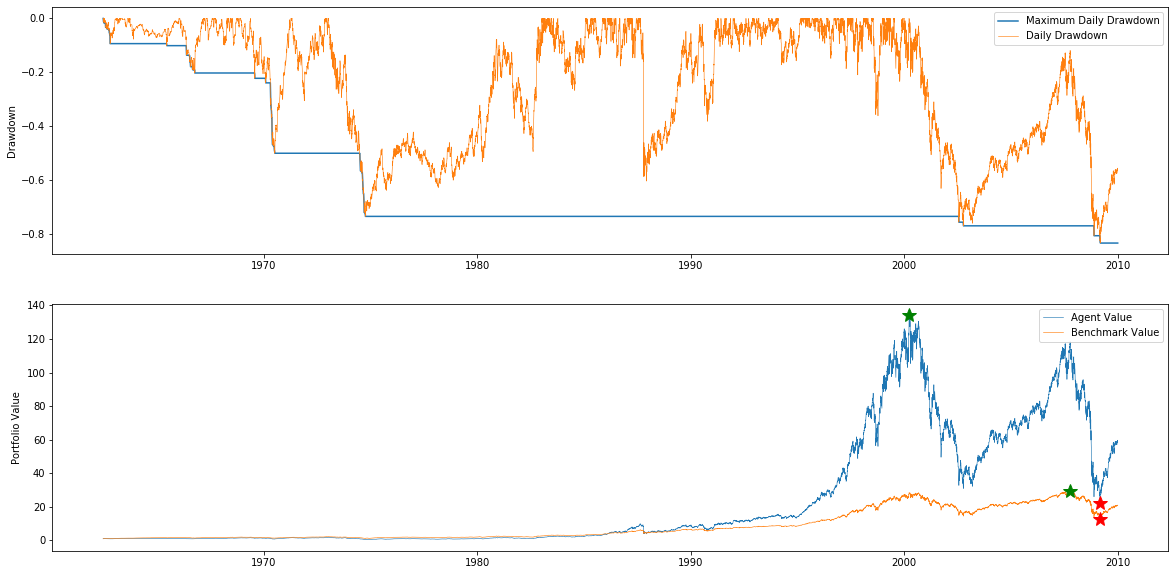

In [94]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

ax1.plot(-train_Daily_MaxDD,label='Maximum Daily Drawdown',linewidth=1.5)
ax1.plot(-train_Daily_DD,label='Daily Drawdown',linewidth=0.6)
ax1.set_ylabel('Drawdown')
ax1.legend()

ax2.plot(train_value,label='Agent Value',linewidth=0.6)
ax2.plot(train_mkt_value,label='Benchmark Value',linewidth=0.6)
ax2.plot(train_d1,train_d1_value,marker="*",c='g',ms=15)
ax2.plot(train_d2,train_d2_value,marker="*",c='r',ms=15)
ax2.plot(train_mkt_d1,train_mkt_d1_value,marker="*",c='g',ms=15)
ax2.plot(train_mkt_d2,train_mkt_d2_value,marker="*",c='r',ms=15)
ax2.set_ylabel('Portfolio Value')
ax2.legend(loc='upper right')

#plt.title("S&P500 Cumulative Value and Maximum Drawdown (Train) ")
plt.show()

## Test

In [68]:
test_summary

2010            0.253179
2011           -0.043740
2012            0.265104
2013            0.577986
2014            0.159134
2015           -0.069997
2016            0.124213
2017            0.178482
2018           -0.289992
2019            0.346131
mean            0.150050
std             0.241895
min            -0.289992
max             0.577986
Ann_Ret         0.125630
Ann_Vol         0.059442
Sharpe Ratio    2.113508
VaR            -0.029608
CVaR           -0.042957
MMD             0.420687
Name: sim_return, dtype: float64

In [95]:
test_value.tail(1)

Date
2019-12-31    3.265565
Name: sim_return, dtype: float64

In [96]:
test_mkt_value.tail(1)

Date
2019-12-31    2.88879
Name: mkt_return, dtype: float64

In [69]:
test_mkt_summary

2010            0.127827
2011           -0.000032
2012            0.134057
2013            0.296012
2014            0.113906
2015           -0.007266
2016            0.095350
2017            0.194200
2018           -0.062373
2019            0.284995
mean            0.117668
std             0.119454
min            -0.062373
max             0.296012
Ann_Ret         0.111915
Ann_Vol         0.032232
Sharpe Ratio    3.472178
VaR            -0.015406
CVaR           -0.023128
MMD             0.197782
Name: mkt_return, dtype: float64

In [77]:
test_MaxDD,test_Daily_MaxDD,test_Daily_DD,test_d2,test_d1,test_d1_value,test_d2_value = Maximum_DD(test_value)
test_mkt_MaxDD,test_mkt_Daily_MaxDD,test_mkt_Daily_DD,test_mkt_d2,test_mkt_d1,test_mkt_d1_value,test_mkt_d2_value = Maximum_DD(test_mkt_value)
print('For agent:')
print('The highest value happened at the end of',test_d1)
print('The highest maximum drawdown happened at the end of',test_d2)
print('the maximum drawdown period is from %s to %s.' % (test_d1,test_d2))
print('\n')
print('For market')
print('The highest value happened at the end of',test_mkt_d1)
print('The highest maximum drawdown happened at the end of',test_mkt_d2)
print('the maximum drawdown period is from %s to %s.' % (test_mkt_d1,test_mkt_d2))
print('\n')

For agent:
The highest value happened at the end of 2018-01-26 00:00:00
The highest maximum drawdown happened at the end of 2018-12-24 00:00:00
the maximum drawdown period is from 2018-01-26 00:00:00 to 2018-12-24 00:00:00.


For market
The highest value happened at the end of 2018-09-20 00:00:00
The highest maximum drawdown happened at the end of 2018-12-24 00:00:00
the maximum drawdown period is from 2018-09-20 00:00:00 to 2018-12-24 00:00:00.




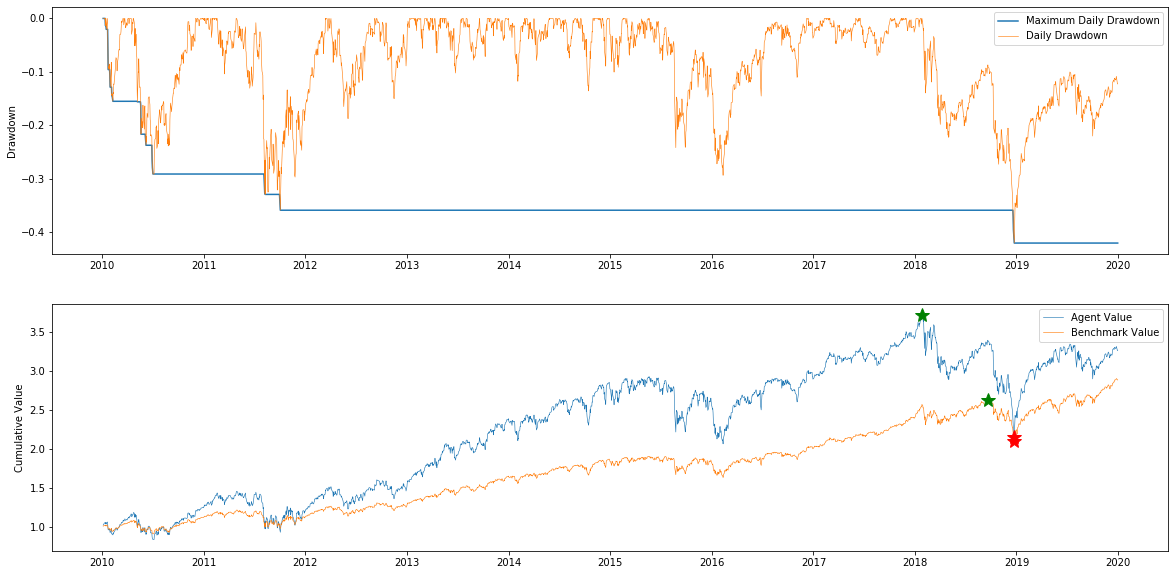

In [100]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

ax1.plot(-test_Daily_MaxDD,label='Maximum Daily Drawdown',linewidth=1.5)
ax1.plot(-test_Daily_DD,label='Daily Drawdown',linewidth=0.6)
ax1.set_ylabel('Drawdown')
ax1.legend()

ax2.plot(test_value,label='Agent Value',linewidth=0.6)
ax2.plot(test_mkt_value,label='Benchmark Value',linewidth=0.6)
ax2.plot(test_d1,test_d1_value,marker="*",c='g',ms=15)
ax2.plot(test_d2,test_d2_value,marker="*",c='r',ms=15)
ax2.plot(test_mkt_d1,test_mkt_d1_value,marker="*",c='g',ms=15)
ax2.plot(test_mkt_d2,test_mkt_d2_value,marker="*",c='r',ms=15)
ax2.set_ylabel('Cumulative Value')
ax2.legend(loc='upper right')

#plt.title("^GSPC ")
plt.show()